# ADS

# All types of accidents - Manchester

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/2453718181.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


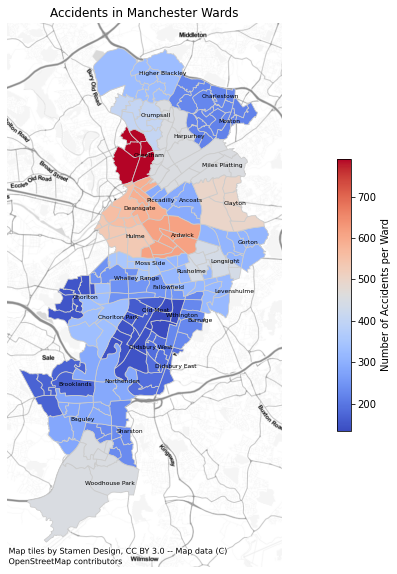

In [135]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')


# Read the data from the DataFrame
data = df

# Filter data to show accidents in Manchester
manchester_data = data[data["local_authority_district"] == "Manchester District (B)"]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# # Convert the CRS of the accidents GeoDataFrame to match the CRS of the Manchester wards GeoDataFrame
# accidents_gdf = accidents_gdf.to_crs(manchester_wards_gdf.crs)

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")


# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()


# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Accidents in Manchester Wards')
plt.savefig('all_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [136]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
Cheetham Ward                         791
Ardwick Ward                          613
Piccadilly Ward                       589
Deansgate Ward                        558
Hulme Ward                            534
Clayton & Openshaw Ward               496
Miles Platting & Newton Heath Ward    457
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/23537529.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


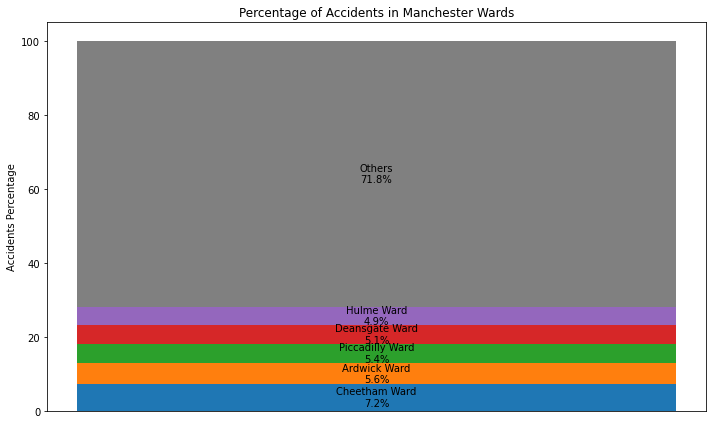

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the accidents_per_ward data
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "Others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bottom = 0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    ax.bar(1, pct, width=0.5, bottom=bottom, color=colors[i])
    ax.text(1, bottom + (pct / 2), f"{ward}\n{pct:.1f}%", fontsize=10, color='black', va='center', ha='center')
    bottom += pct

# Add a title and display the stacked bar chart
ax.set_title("Percentage of Accidents in Manchester Wards")
ax.set_xticks([])
ax.set_ylabel("Accidents Percentage")
plt.tight_layout()
plt.savefig('stacked_bar_All_Manchester_wards_accidents.png', dpi=600, bbox_inches='tight')
plt.show()


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/2613081846.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


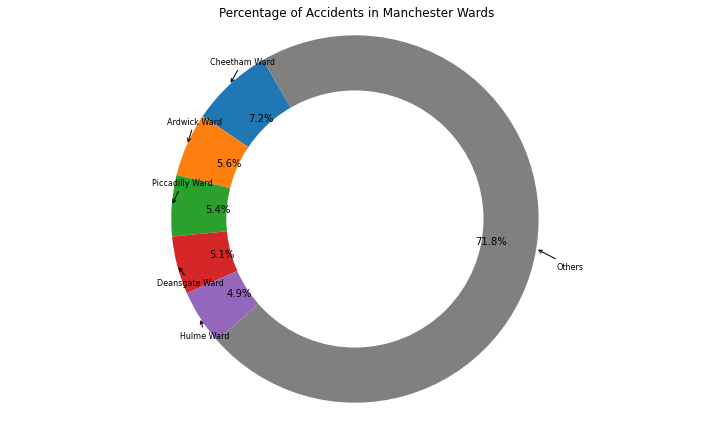

In [89]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')


# Add a title and display the pie chart
ax.set_title("Percentage of Accidents in Manchester Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_All_Manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [90]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



      Ward_Name Percentage
  Cheetham Ward      7.22%
   Ardwick Ward      5.60%
Piccadilly Ward      5.38%
 Deansgate Ward      5.09%
     Hulme Ward      4.87%
         Others     71.84%


# All types of accidents - Liverpool

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/4090437239.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


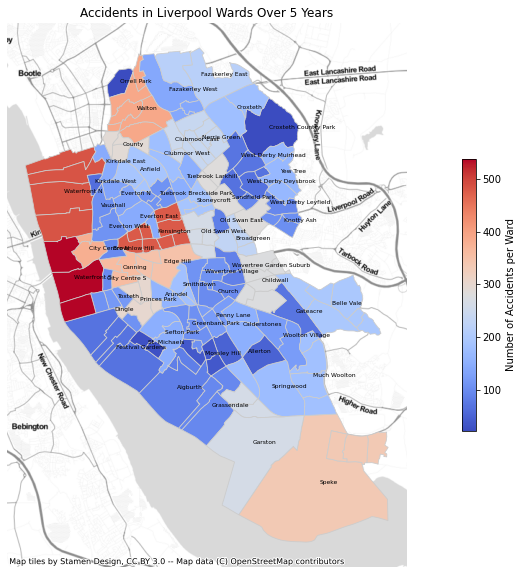

In [91]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Liverpool" with "Liverpool District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Liverpool', 'Liverpool District (B)')

# Filter data to show accidents in Liverpool involving all
liverpool_data = df[(df["local_authority_district"] == "Liverpool District (B)")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Liverpool District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.replace("North", "N").strip()
    ward_name = ward_name.replace("South", "S").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Accidents in Liverpool Wards Over 5 Years')
plt.savefig('ALL_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [92]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
Waterfront South Ward          538
Waterfront North Ward          484
Kensington & Fairfield Ward    478
Walton Ward                    390
City Centre North Ward         380
Canning Ward                   359
Edge Hill Ward                 347
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1429250316.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


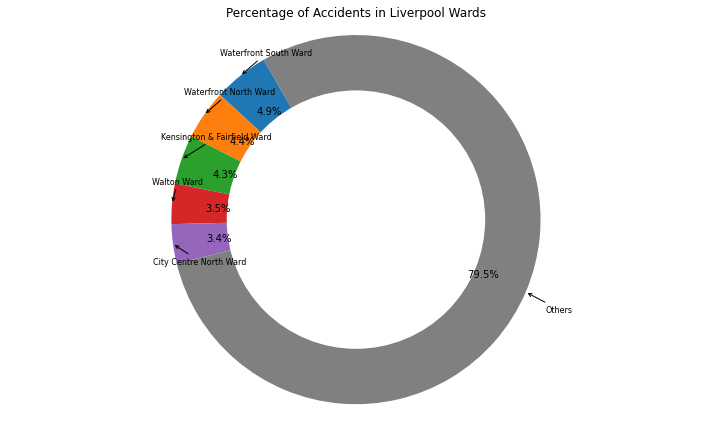

In [93]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')




# Add a title and display the pie chart
ax.set_title("Percentage of Accidents in Liverpool Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_All_Liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [94]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                  Ward_Name Percentage
      Waterfront South Ward      4.86%
      Waterfront North Ward      4.37%
Kensington & Fairfield Ward      4.31%
                Walton Ward      3.52%
     City Centre North Ward      3.43%
                     Others     79.51%


# All types of accidents - Sheffield

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1354680766.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


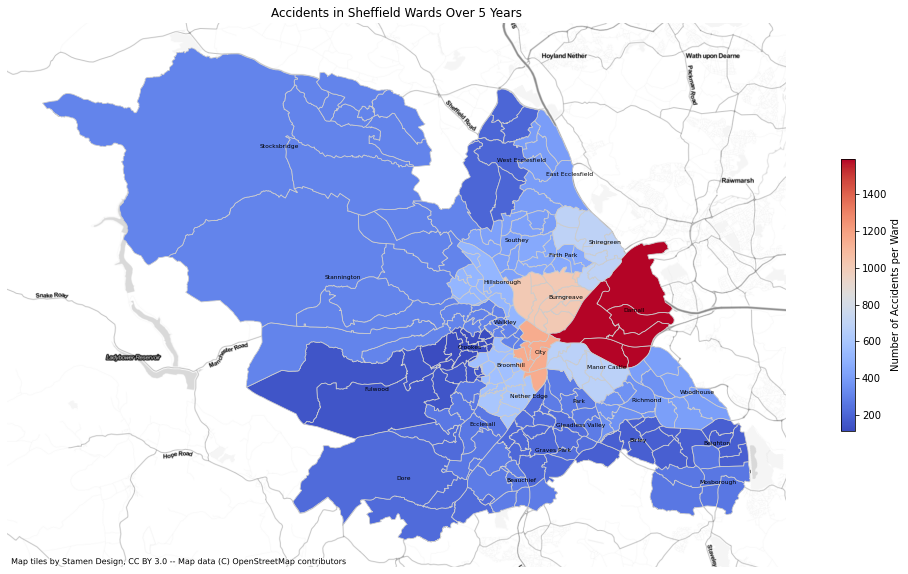

In [95]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving cyclists
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Accidents in Sheffield Wards Over 5 Years')
plt.savefig('All_sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [96]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))



Ward
Darnall Ward                     1588
City Ward                        1145
Burngreave Ward                  1009
Shiregreen & Brightside Ward      691
Manor Castle Ward                 682
Nether Edge & Sharrow Ward        602
Broomhill & Sharrow Vale Ward     569
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3543226683.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


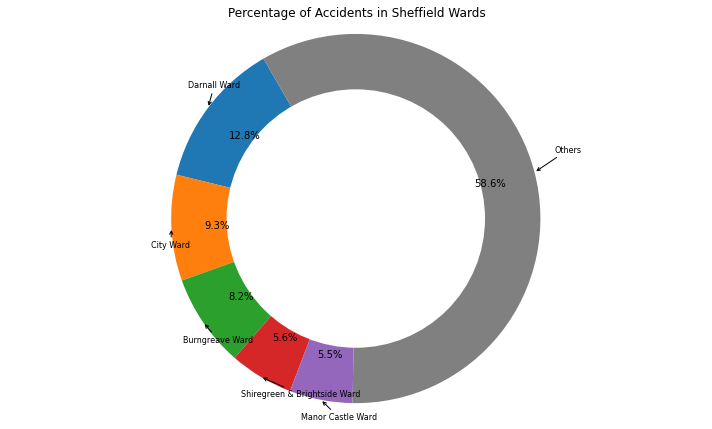

In [97]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Accidents in Sheffield Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_All_Sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [98]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                   Ward_Name Percentage
                Darnall Ward     12.85%
                   City Ward      9.27%
             Burngreave Ward      8.16%
Shiregreen & Brightside Ward      5.59%
           Manor Castle Ward      5.52%
                      Others     58.61%


# Manchester Cyclist

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1293233811.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


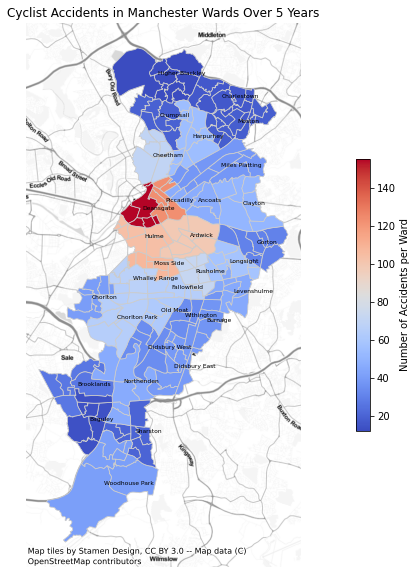

In [99]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')


# Filter data to show accidents in Manchester involving cyclists
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["casualty_type"] == "Cyclist")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# # Convert the CRS of the accidents GeoDataFrame to match the CRS of the Manchester wards GeoDataFrame
# accidents_gdf = accidents_gdf.to_crs(manchester_wards_gdf.crs)

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")


# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()


# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Manchester Wards Over 5 Years')
plt.savefig('cyclist_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [100]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))



Ward
Deansgate Ward     155
Piccadilly Ward    123
Moss Side Ward     107
Hulme Ward         104
Ardwick Ward        99
Rusholme Ward       72
Cheetham Ward       70
Name: Ward, dtype: int64


In [101]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Cyclist Accidents in Manchester Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Cyclist_Manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3871360264.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


In [102]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



      Ward_Name Percentage
 Deansgate Ward      9.07%
Piccadilly Ward      7.20%
 Moss Side Ward      6.26%
     Hulme Ward      6.09%
   Ardwick Ward      5.79%
         Others     65.59%


# Liverpool Cyclist

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3983175908.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


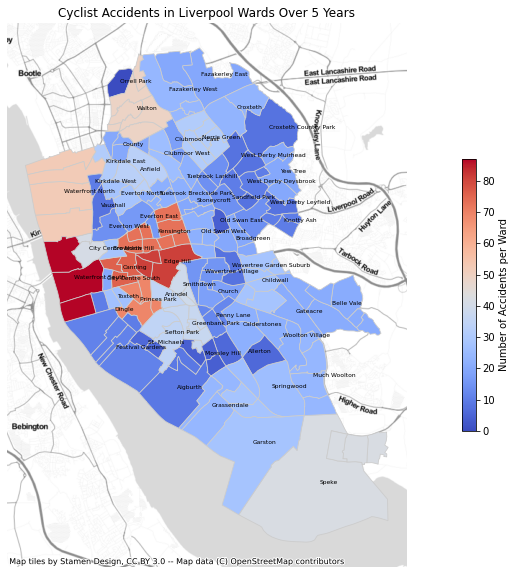

In [103]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Liverpool" with "Liverpool District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Liverpool', 'Liverpool District (B)')

# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool District (B)") & (df["casualty_type"] == "Cyclist")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Liverpool District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Liverpool Wards Over 5 Years')
plt.savefig('cyclist_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [104]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))



Ward
Waterfront South Ward          87
Edge Hill Ward                 81
Canning Ward                   76
Kensington & Fairfield Ward    73
Princes Park Ward              69
Waterfront North Ward          52
Walton Ward                    49
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1574591369.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


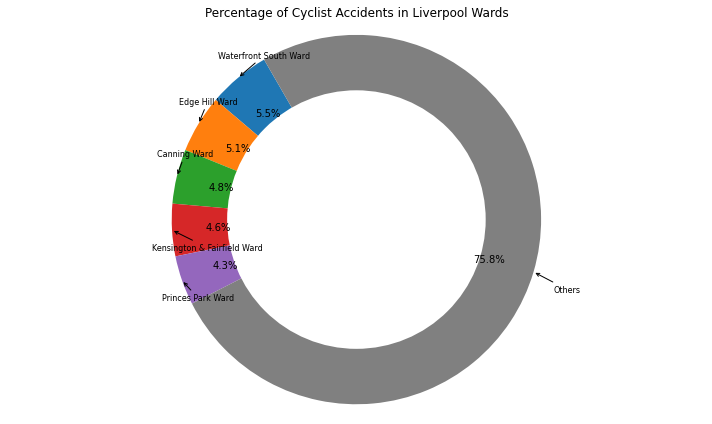

In [105]:

# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Cyclist Accidents in Liverpool Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Cyclist_Liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()



In [106]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                  Ward_Name Percentage
      Waterfront South Ward      5.45%
             Edge Hill Ward      5.08%
               Canning Ward      4.76%
Kensington & Fairfield Ward      4.57%
          Princes Park Ward      4.32%
                     Others     75.81%


# Sheffield Cyclist

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3029752410.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


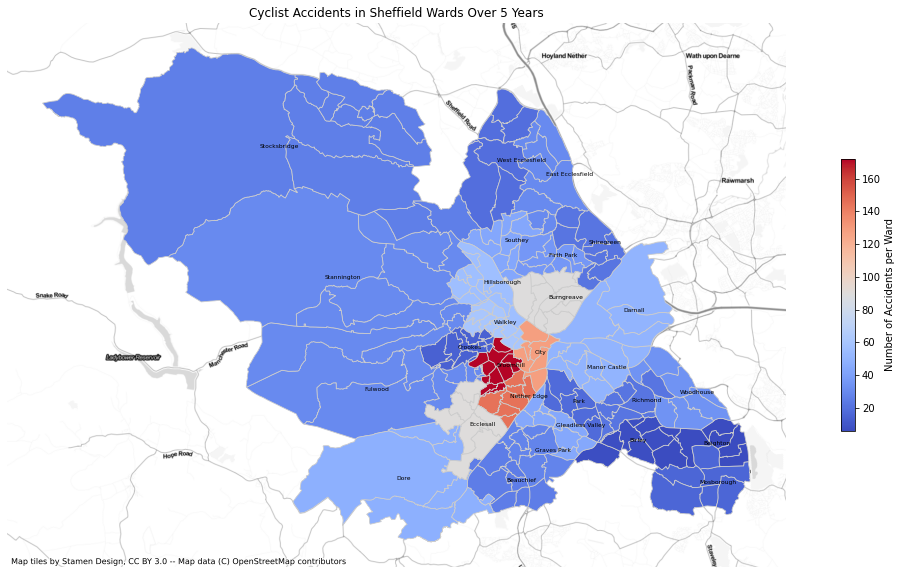

In [107]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving cyclists
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)") & (df["casualty_type"] == "Cyclist")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Sheffield Wards Over 5 Years')
plt.savefig('cyclist_sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [108]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
Broomhill & Sharrow Vale Ward    172
Nether Edge & Sharrow Ward       145
City Ward                        128
Ecclesall Ward                    90
Burngreave Ward                   89
Walkley Ward                      61
Hillsborough Ward                 56
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1325616990.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


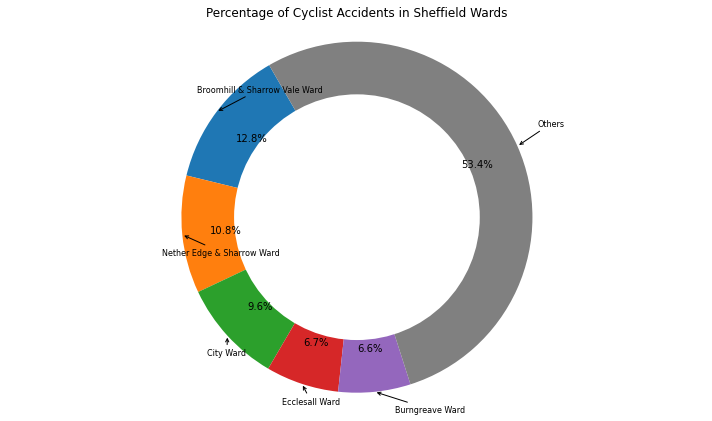

In [109]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Cyclist Accidents in Sheffield Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Cyclist_Sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [110]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                    Ward_Name Percentage
Broomhill & Sharrow Vale Ward     12.85%
   Nether Edge & Sharrow Ward     10.83%
                    City Ward      9.56%
               Ecclesall Ward      6.72%
              Burngreave Ward      6.65%
                       Others     53.40%


# Childern Under 16 Manchester

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/862537951.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


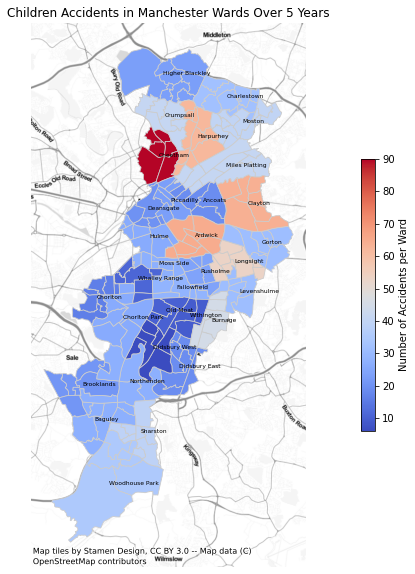

In [111]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')


# Filter data to show accidents in Manchester involving Children
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# # Convert the CRS of the accidents GeoDataFrame to match the CRS of the Manchester wards GeoDataFrame
# accidents_gdf = accidents_gdf.to_crs(manchester_wards_gdf.crs)

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")


# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()


# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Manchester Wards Over 5 Years')
plt.savefig('Children_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [112]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))




Ward
Cheetham Ward              90
Ardwick Ward               65
Clayton & Openshaw Ward    64
Harpurhey Ward             62
Longsight Ward             53
Burnage Ward               45
Crumpsall Ward             41
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/2878351896.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


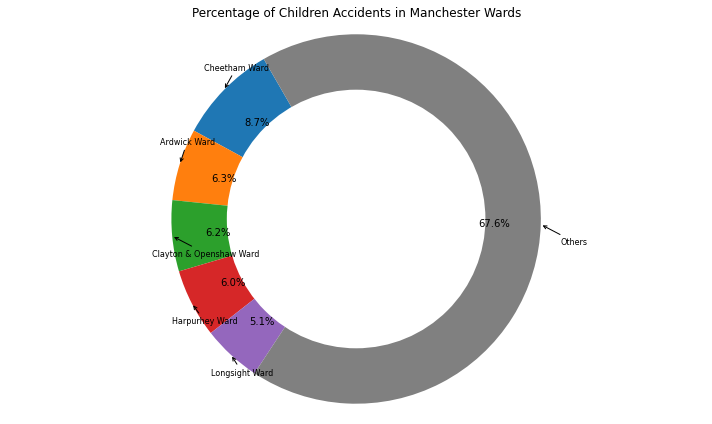

In [113]:

# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')




# Add a title and display the pie chart
ax.set_title("Percentage of Children Accidents in Manchester Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Children_Manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [114]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



              Ward_Name Percentage
          Cheetham Ward      8.73%
           Ardwick Ward      6.30%
Clayton & Openshaw Ward      6.21%
         Harpurhey Ward      6.01%
         Longsight Ward      5.14%
                 Others     67.60%


# Children Under 16 Liverpool

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/4281507586.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


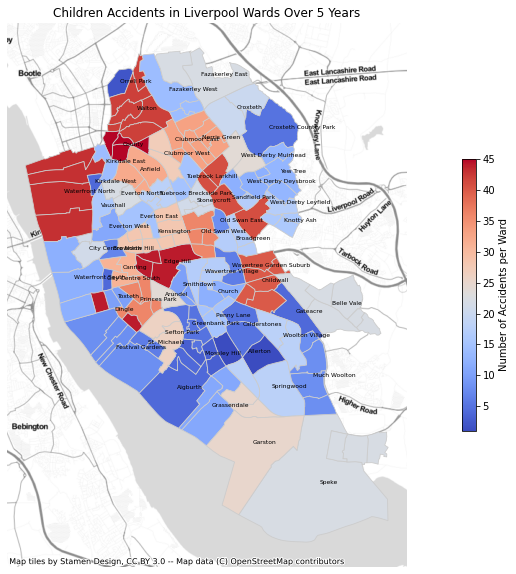

In [115]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Liverpool" with "Liverpool District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Liverpool', 'Liverpool District (B)')

# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool District (B)") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Liverpool District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Liverpool Wards Over 5 Years')
plt.savefig('Children_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [116]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))





Ward
County Ward              45
Edge Hill Ward           44
Dingle Ward              44
Waterfront North Ward    43
Walton Ward              42
Sandfield Park Ward      41
Childwall Ward           40
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/2080138337.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


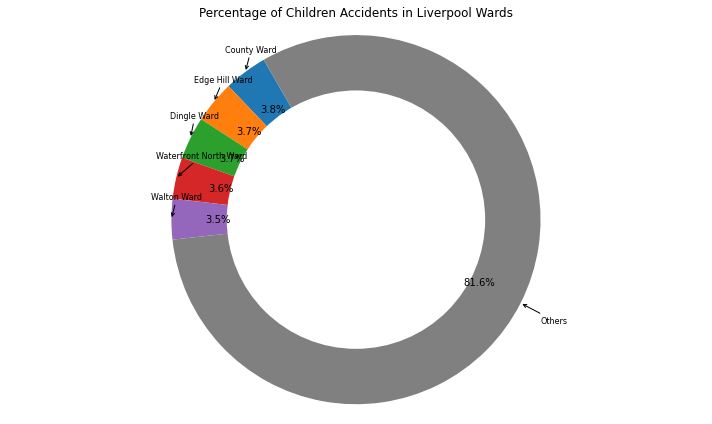

In [117]:

# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')




# Add a title and display the pie chart
ax.set_title("Percentage of Children Accidents in Liverpool Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Children_Liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [118]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



            Ward_Name Percentage
          County Ward      3.80%
       Edge Hill Ward      3.71%
          Dingle Ward      3.71%
Waterfront North Ward      3.63%
          Walton Ward      3.54%
               Others     81.60%


# Children Under 16 Sheffield

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/989328964.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


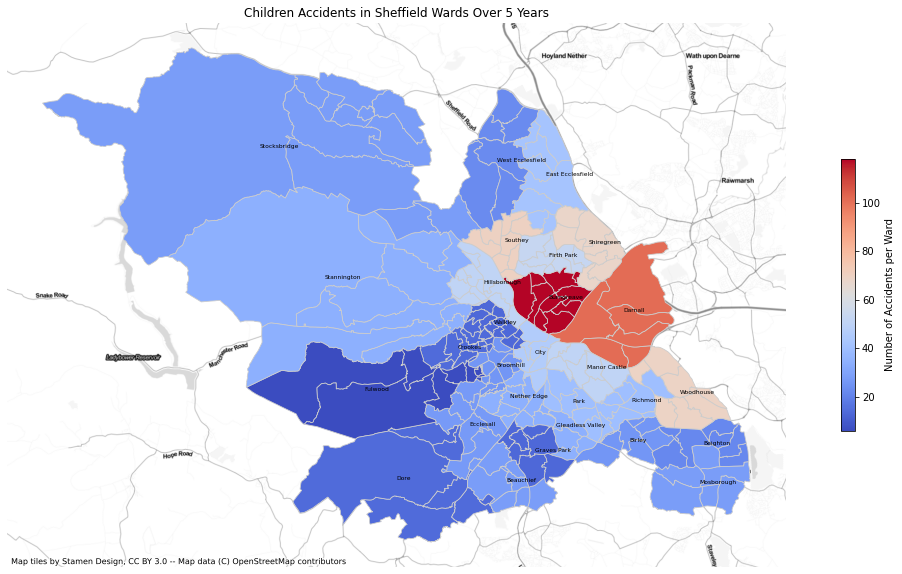

In [119]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving cyclists
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Sheffield Wards Over 5 Years')
plt.savefig('Children_sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()



In [120]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
Burngreave Ward                 118
Darnall Ward                    101
Southey Ward                     70
Woodhouse Ward                   69
Shiregreen & Brightside Ward     68
Firth Park Ward                  53
Hillsborough Ward                51
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3516943866.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


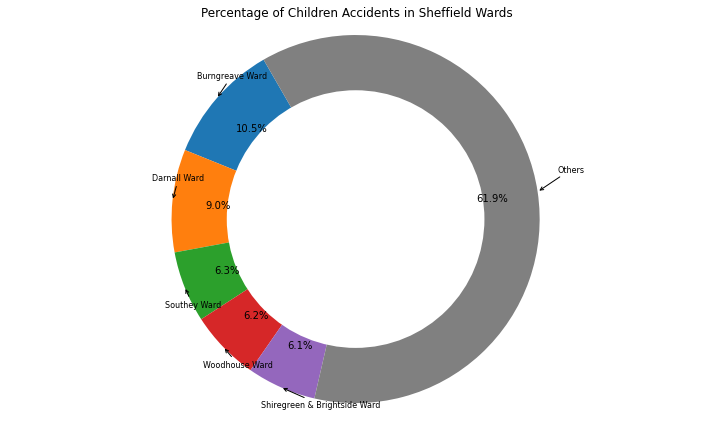

In [121]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')




# Add a title and display the pie chart
ax.set_title("Percentage of Children Accidents in Sheffield Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Children_Sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [122]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                   Ward_Name Percentage
             Burngreave Ward     10.55%
                Darnall Ward      9.03%
                Southey Ward      6.26%
              Woodhouse Ward      6.17%
Shiregreen & Brightside Ward      6.08%
                      Others     61.93%


# Pedestrian Manchester

In [123]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')


# Filter data to show accidents in Manchester involving Pedestrian
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["casualty_type"] == "Pedestrian")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# # Convert the CRS of the accidents GeoDataFrame to match the CRS of the Manchester wards GeoDataFrame
# accidents_gdf = accidents_gdf.to_crs(manchester_wards_gdf.crs)

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")


# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()


# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Manchester Wards Over 5 Years')
plt.savefig('Pedestrian_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3679684223.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [124]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
Piccadilly Ward    109
Deansgate Ward     104
Cheetham Ward       75
Longsight Ward      62
Ardwick Ward        50
Harpurhey Ward      46
Hulme Ward          46
Name: Ward, dtype: int64


In [125]:

# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Pedestrian Accidents in Manchester Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Pedestrian_Manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()



/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/46861435.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


In [126]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



      Ward_Name Percentage
Piccadilly Ward     10.34%
 Deansgate Ward      9.87%
  Cheetham Ward      7.12%
 Longsight Ward      5.88%
   Ardwick Ward      4.74%
         Others     62.05%


# Pedestrian Liverpool

In [127]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Liverpool" with "Liverpool District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Liverpool', 'Liverpool District (B)')

# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool District (B)") & (df["casualty_type"] == "Pedestrian")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Liverpool District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Liverpool Wards Over 5 Years')
plt.savefig('Pedestrian_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1706155174.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [128]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))



Ward
City Centre North Ward         137
Waterfront South Ward          134
Kensington & Fairfield Ward     69
Walton Ward                     56
Dingle Ward                     52
Princes Park Ward               47
Canning Ward                    42
Name: Ward, dtype: int64


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/1879348408.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


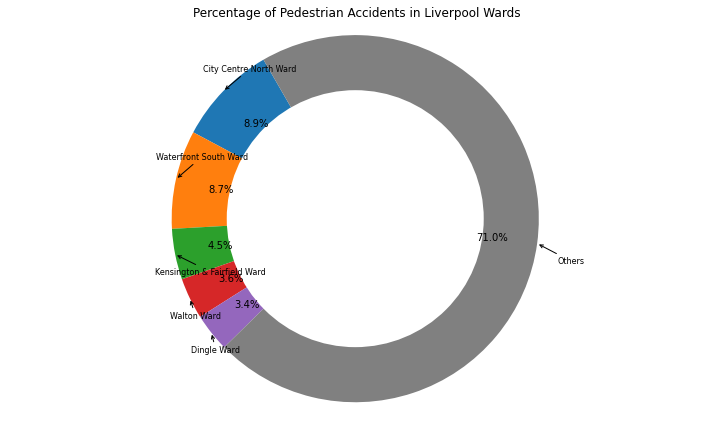

In [129]:

# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Pedestrian Accidents in Liverpool Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Pedestrian_Liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [130]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))



                  Ward_Name Percentage
     City Centre North Ward      8.87%
      Waterfront South Ward      8.68%
Kensington & Fairfield Ward      4.47%
                Walton Ward      3.63%
                Dingle Ward      3.37%
                     Others     70.98%


# Pedestrian Sheffield

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/3312096848.py:9: DtypeWarning: Columns (0,2,37,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


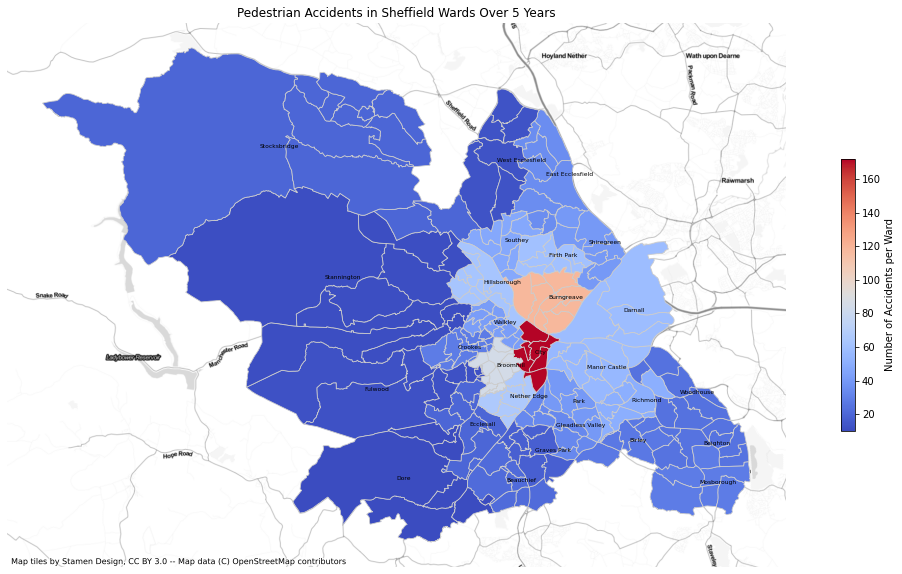

In [131]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving cyclists
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)") & (df["casualty_type"] == "Pedestrian")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Plot the map
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column='accidents', cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax,
                          legend_kwds={'shrink': 0.5, 'label': "Number of Accidents per Ward"})

# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Sheffield Wards Over 5 Years')
plt.savefig('Pedestrian_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()



In [132]:
# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Sort the accidents_per_ward series in descending order
top_accidents_per_ward = accidents_per_ward.sort_values(ascending=False)

# Display the top wards by the number of accidents (you can adjust the number of top wards to display by changing the value inside head())
print(top_accidents_per_ward.head(7))


Ward
City Ward                        172
Burngreave Ward                  118
Broomhill & Sharrow Vale Ward     85
Nether Edge & Sharrow Ward        66
Hillsborough Ward                 63
Firth Park Ward                   60
Darnall Ward                      58
Name: Ward, dtype: int64


In [133]:
# Calculate the percentage of accidents for each ward
total_accidents = accidents_per_ward.sum()
accidents_percentage = (accidents_per_ward / total_accidents) * 100

# Sort the accidents_percentage series in descending order
top_accidents_percentage = accidents_percentage.sort_values(ascending=False)

# Group the remaining wards into an "others" category
others_percentage = top_accidents_percentage[5:].sum()
top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))

# Specify colors for the pie chart
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'gray']

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts = ax.pie(top_accidents_percentage, startangle=120, colors=colors)

# Add a white circle in the middle of the pie chart for aesthetics
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add percentages for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * 0.75 * np.cos(angle_rad)
    y = wedges[i].r * 0.75 * np.sin(angle_rad)
    ax.annotate(f"{pct:.1f}%",
                xy=(x, y),
                fontsize=10,
                color='black',
                va='center',
                ha='center')

# Add markers for the top 5 wards and "others"
for i, (ward, pct) in enumerate(top_accidents_percentage.items()):
    angle_rad = np.deg2rad(np.mean([wedges[i].theta1, wedges[i].theta2]))
    x = wedges[i].r * np.cos(angle_rad)
    y = wedges[i].r * np.sin(angle_rad)
    ax.annotate(f"{ward}",
                xy=(x, y),
                xytext=(20 * np.sign(x), 20 * np.sign(y)),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->"),
                fontsize=8,
                color='black')





# Add a title and display the pie chart
ax.set_title("Percentage of Pedestrian Accidents in Sheffield Wards")
plt.axis("equal")
plt.tight_layout()
plt.savefig('pie_Pedestrian_Sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_38595/867377250.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_accidents_percentage = top_accidents_percentage.head(5).append(pd.Series({"Others": others_percentage}))


In [134]:

# Create a new DataFrame with the top 7 wards and their percentages
ward_names = pd.Series(top_accidents_percentage.head(7).index, name='Ward_Name')
percentages = pd.Series(top_accidents_percentage.head(7).values, name='Percentage')

top_wards_df = pd.concat([ward_names, percentages], axis=1)

# Format the percentages up to 2 decimals
top_wards_df['Percentage'] = top_wards_df['Percentage'].map('{:.2f}%'.format)

# Display the table without index
print(top_wards_df.to_string(index=False))


                    Ward_Name Percentage
                    City Ward     14.09%
              Burngreave Ward      9.66%
Broomhill & Sharrow Vale Ward      6.96%
   Nether Edge & Sharrow Ward      5.41%
            Hillsborough Ward      5.16%
                       Others     58.72%
